In [1]:
import numpy as np
import pandas as pd


In [2]:
df = pd.read_csv('loan_dataset.csv')
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [3]:
y = df['Loan_Status'].values
y_trans = (y=="Y") + 0

In [4]:
# Get numerical and categorical features
features = df.columns.values
ignore_features = ['Loan_ID','Loan_Status']
num_features = []
cat_features = []
# categorical features
for f in features:
    if f not in ignore_features and df[f].dtype == 'object':
        cat_features.append(f)
# numerical features
for f in features:
    if f not in ignore_features and f not in cat_features:
        num_features.append(f)
print(num_features)
print(cat_features)

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


In [5]:
# inpute missing values
from sklearn.impute import SimpleImputer
num_inputer = SimpleImputer(missing_values=np.nan, strategy='mean')
cat_inputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Missing')

df_num = num_inputer.fit_transform(df[num_features])
df_cat = cat_inputer.fit_transform(df[cat_features])


In [6]:
# transform and combine num & cat features
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False)
df_num_trans = scaler.fit_transform(df_num)
df_cat_trans = encoder.fit_transform(df_cat)
X = np.hstack((df_num_trans,df_cat_trans))

In [7]:
# train test split
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.3
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [8]:
# fit model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
log_model = LogisticRegression()
log_model = log_model.fit(X_train, y_train)
y_hat = log_model.predict(X_test)
score = f1_score(y_test,y_hat)
score

0.8550724637681159

In [9]:
# use foreach in metaflow
test_groups = cat_features #['Gender', 'Married','Dependents','Education']

In [10]:
# example of gender
# separate groups
input = 'Gender'
group_col = df[input]
unique_groups = group_col.unique()

X_groups = []
group_names = []
for group in unique_groups:
    if group is not np.nan:
        group_names.append(group)
        X_groups.append(X[group_col==group])

approve_rates = {}
for i in range(len(group_names)):
    y_pred_approve = log_model.predict(X_groups[i])
    approve_rates[group_names[i]] = (y_pred_approve.sum() / len(X_groups[i]))

approve_rates

{'Male': 0.8568507157464212, 'Female': 0.8482142857142857}

In [11]:
X_groups[0].shape

(489, 24)

In [54]:
plot_rates = pd.Series(approve_rates)
plot_rates.index

Index(['Male', 'Female'], dtype='object')

(0.0, 1.0)

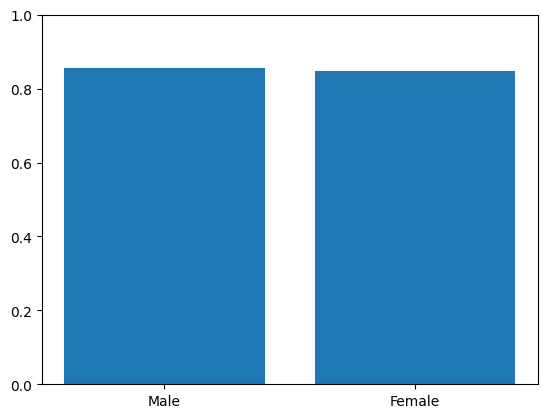

In [57]:
import matplotlib.pyplot as plt
plt.bar(plot_rates.index, height=plot_rates)
plt.ylim(0,1)